In [1]:
# ============================================================================
# COFFEE QUALITY IDENTIFICATION USING CLUSTERING
# Dataset 6 - Machine Learning Project
# ============================================================================
# This script is designed to run in Google Colab
# Upload Dataset_6.csv to /content/ folder in Colab
# ============================================================================

# ============================================================================
# SECTION 1: Import Libraries and Load Data
# ============================================================================

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Load the dataset
# Make sure Dataset_6.csv is uploaded to /content/ in Google Colab
df = pd.read_csv('/content/Dataset_6.csv')

# Display basic information about the dataset
print("\nDataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())


Libraries imported successfully!

Dataset shape: (207, 41)

First few rows:
   Unnamed: 0  ID Country of Origin                 Farm Name  \
0           0   0          Colombia          Finca El Paraiso   
1           1   1            Taiwan  Royal Bean Geisha Estate   
2           2   2              Laos        OKLAO coffee farms   
3           3   3        Costa Rica                 La Cumbre   
4           4   4          Colombia           Finca Santuario   

                                Lot Number                           Mill  \
0                               CQU2022015               Finca El Paraiso   
1  The 2022 Pacific Rim Coffee Summit,T037       Royal Bean Geisha Estate   
2  The 2022 Pacific Rim Coffee Summit,LA01  oklao coffee processing plant   
3                               CQU2022017        La Montana Tarrazu MIll   
4                               CQU2023002                Finca Santuario   

  ICO Number                   Company   Altitude                Regio


DATA EXPLORATION

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             207 non-null    int64  
 1   ID                     207 non-null    int64  
 2   Country of Origin      207 non-null    object 
 3   Farm Name              205 non-null    object 
 4   Lot Number             206 non-null    object 
 5   Mill                   204 non-null    object 
 6   ICO Number             75 non-null     object 
 7   Company                207 non-null    object 
 8   Altitude               206 non-null    object 
 9   Region                 205 non-null    object 
 10  Producer               206 non-null    object 
 11  Number of Bags         207 non-null    int64  
 12  Bag Weight             207 non-null    object 
 13  In-Country Partner     207 non-null    object 
 14  Harvest Year           20

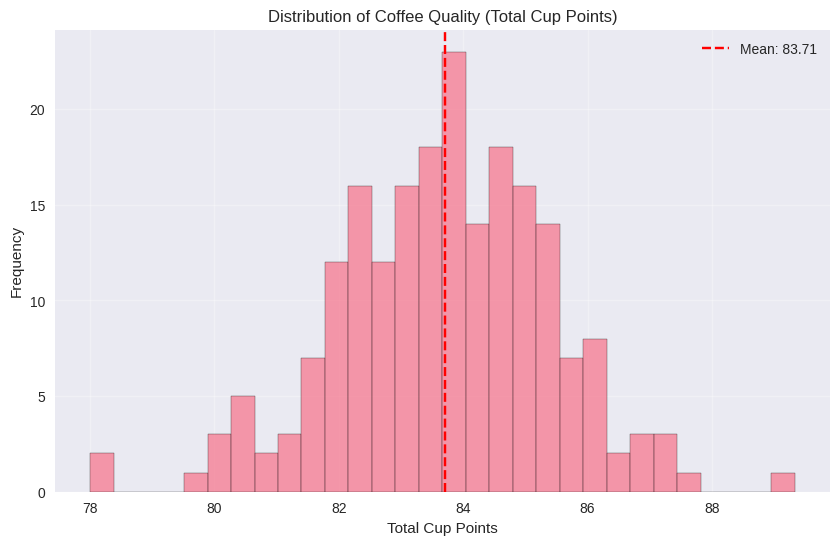


Average Total Cup Points: 83.71
Highest Score: 89.33
Lowest Score: 78.00


In [2]:

# ============================================================================
# SECTION 2: Data Exploration and Understanding
# ============================================================================

# Check data types and missing values
print("\n" + "="*60)
print("DATA EXPLORATION")
print("="*60)

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(f"Total missing values: {df.isnull().sum().sum()}")

# Identify quality-related columns for clustering
quality_columns = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
                   'Balance', 'Uniformity', 'Clean Cup', 'Sweetness',
                   'Overall', 'Total Cup Points']

print("\nQuality metrics columns:")
for col in quality_columns:
    if col in df.columns:
        print(f"  - {col}")

# Display basic statistics for quality metrics
print("\nBasic Statistics for Quality Metrics:")
print(df[quality_columns].describe())

# Visualize distribution of Total Cup Points
plt.figure(figsize=(10, 6))
plt.hist(df['Total Cup Points'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Total Cup Points')
plt.ylabel('Frequency')
plt.title('Distribution of Coffee Quality (Total Cup Points)')
plt.axvline(df['Total Cup Points'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["Total Cup Points"].mean():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nAverage Total Cup Points: {df['Total Cup Points'].mean():.2f}")
print(f"Highest Score: {df['Total Cup Points'].max():.2f}")
print(f"Lowest Score: {df['Total Cup Points'].min():.2f}")

In [3]:

# ============================================================================
# SECTION 3: Data Preprocessing
# ============================================================================

print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)

# Select only the quality metric columns for clustering
clustering_features = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
                      'Balance', 'Uniformity', 'Clean Cup', 'Sweetness', 'Overall']

# Create a clean dataset with only quality metrics
df_cluster = df[clustering_features].copy()

# Check for missing values
print("\nMissing values in clustering features:")
print(df_cluster.isnull().sum())

# Remove rows with any missing values
df_cluster_clean = df_cluster.dropna()

print(f"\nOriginal dataset: {len(df_cluster)} rows")
print(f"After removing missing values: {len(df_cluster_clean)} rows")

# Also keep the corresponding Total Cup Points for analysis
df_total_points = df.loc[df_cluster_clean.index, 'Total Cup Points']

# Standardize the data (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_clean)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features, index=df_cluster_clean.index)

print("\nData standardized successfully!")
print(f"Scaled data shape: {X_scaled_df.shape}")



DATA PREPROCESSING

Missing values in clustering features:
Aroma         0
Flavor        0
Aftertaste    0
Acidity       0
Body          0
Balance       0
Uniformity    0
Clean Cup     0
Sweetness     0
Overall       0
dtype: int64

Original dataset: 207 rows
After removing missing values: 207 rows

Data standardized successfully!
Scaled data shape: (207, 10)



DETERMINING OPTIMAL NUMBER OF CLUSTERS


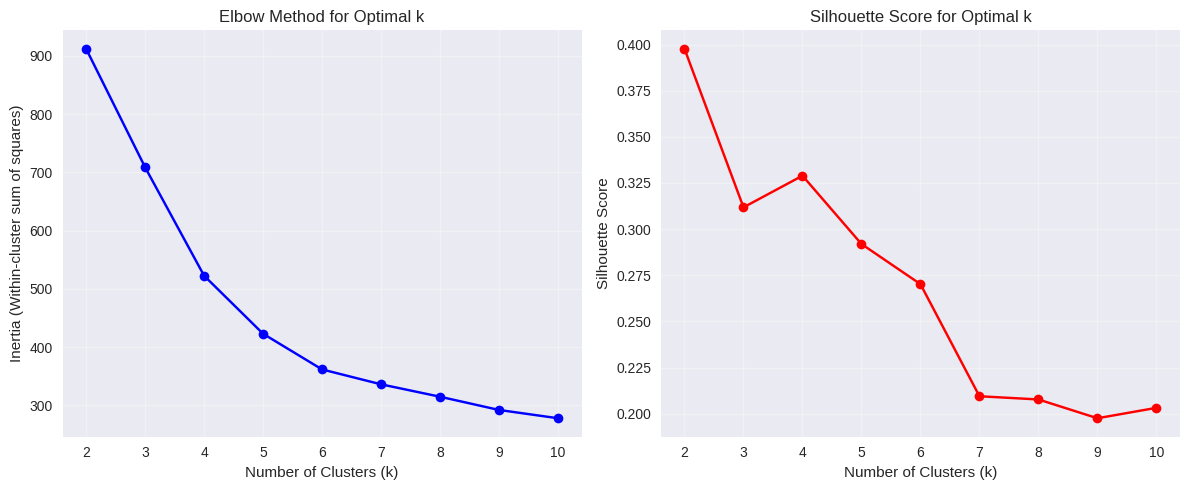


Optimal number of clusters: 2
Best Silhouette Score: 0.398


In [4]:

# ============================================================================
# SECTION 4: Determine Optimal Number of Clusters
# ============================================================================

print("\n" + "="*60)
print("DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("="*60)

# Use Elbow Method to find optimal number of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)  # Test from 2 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k (highest silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")
print(f"Best Silhouette Score: {max(silhouette_scores):.3f}")



K-MEANS CLUSTERING

K-Means clustering completed with 2 clusters!

Cluster distribution:
Cluster
0    116
1     91
Name: count, dtype: int64

Average Silhouette Score: 0.398

Cluster Analysis - Average Quality Metrics:
         Aroma  Flavor  Aftertaste  Acidity  Body  Balance  Uniformity  \
Cluster                                                                  
0         7.88    7.93        7.78     7.86  7.78     7.81        9.98   
1         7.51    7.51        7.38     7.48  7.46     7.44       10.00   

         Clean Cup  Sweetness  Overall  Total Cup Points  
Cluster                                                   
0             10.0       10.0     7.89             84.90  
1             10.0       10.0     7.41             82.19  


<Figure size 1400x600 with 0 Axes>

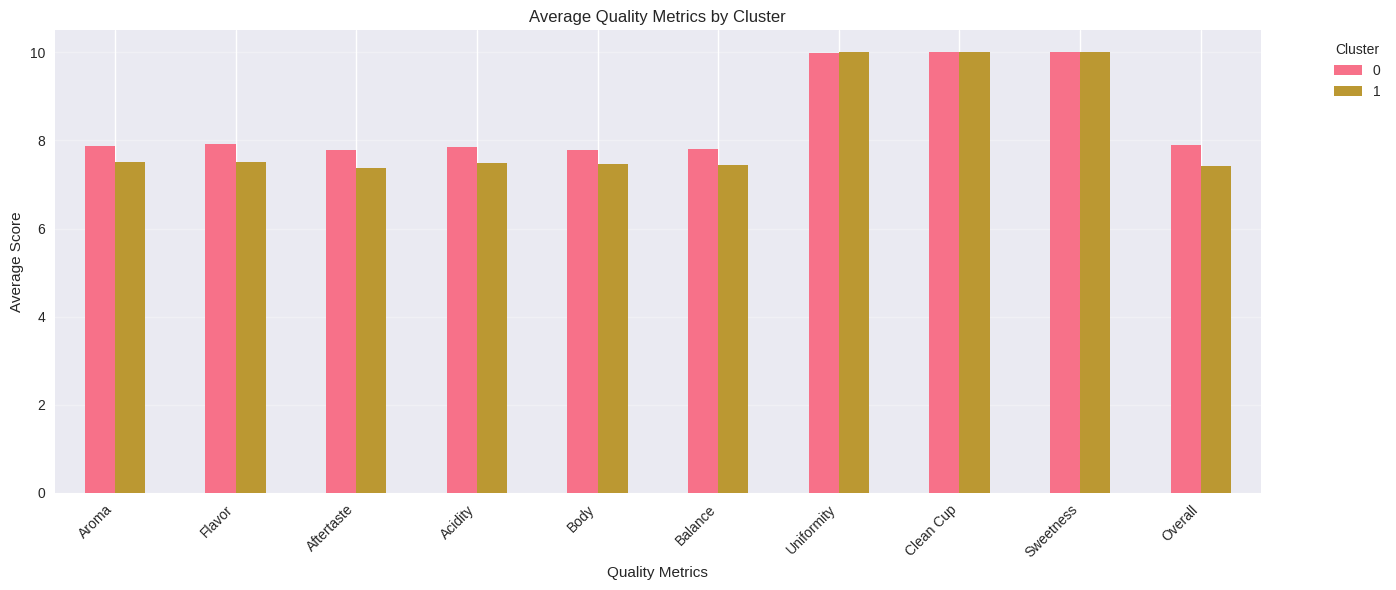

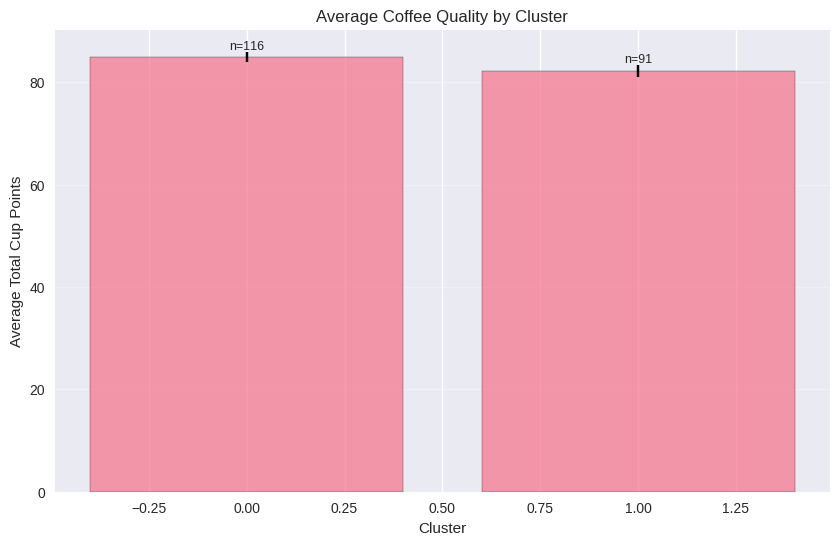


Cluster Quality Summary:
          mean   std  count
Cluster                    
0        84.90  1.05    116
1        82.19  1.13     91


In [5]:

# ============================================================================
# SECTION 5: Apply K-Means Clustering
# ============================================================================

print("\n" + "="*60)
print("K-MEANS CLUSTERING")
print("="*60)

# Apply K-Means clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df_cluster_clean['Cluster'] = cluster_labels
df_cluster_clean['Total Cup Points'] = df_total_points.values

print(f"\nK-Means clustering completed with {optimal_k} clusters!")
print("\nCluster distribution:")
print(df_cluster_clean['Cluster'].value_counts().sort_index())

# Calculate silhouette score
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"\nAverage Silhouette Score: {silhouette_avg:.3f}")

# Analyze each cluster's characteristics
print("\nCluster Analysis - Average Quality Metrics:")
cluster_analysis = df_cluster_clean.groupby('Cluster')[clustering_features + ['Total Cup Points']].mean()
print(cluster_analysis.round(2))

# Visualize cluster characteristics
plt.figure(figsize=(14, 6))
cluster_analysis[clustering_features].T.plot(kind='bar', figsize=(14, 6))
plt.title('Average Quality Metrics by Cluster')
plt.xlabel('Quality Metrics')
plt.ylabel('Average Score')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Analyze Total Cup Points by cluster
plt.figure(figsize=(10, 6))
cluster_quality = df_cluster_clean.groupby('Cluster')['Total Cup Points'].agg(['mean', 'std', 'count'])

plt.bar(cluster_quality.index, cluster_quality['mean'],
        yerr=cluster_quality['std'], capsize=5, alpha=0.7, edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Average Total Cup Points')
plt.title('Average Coffee Quality by Cluster')
plt.grid(True, alpha=0.3, axis='y')

# Add count labels
for i, (idx, row) in enumerate(cluster_quality.iterrows()):
    plt.text(idx, row['mean'] + row['std'] + 0.5, f"n={int(row['count'])}",
             ha='center', fontsize=9)

plt.show()

print("\nCluster Quality Summary:")
print(cluster_quality.round(2))


PCA VISUALIZATION


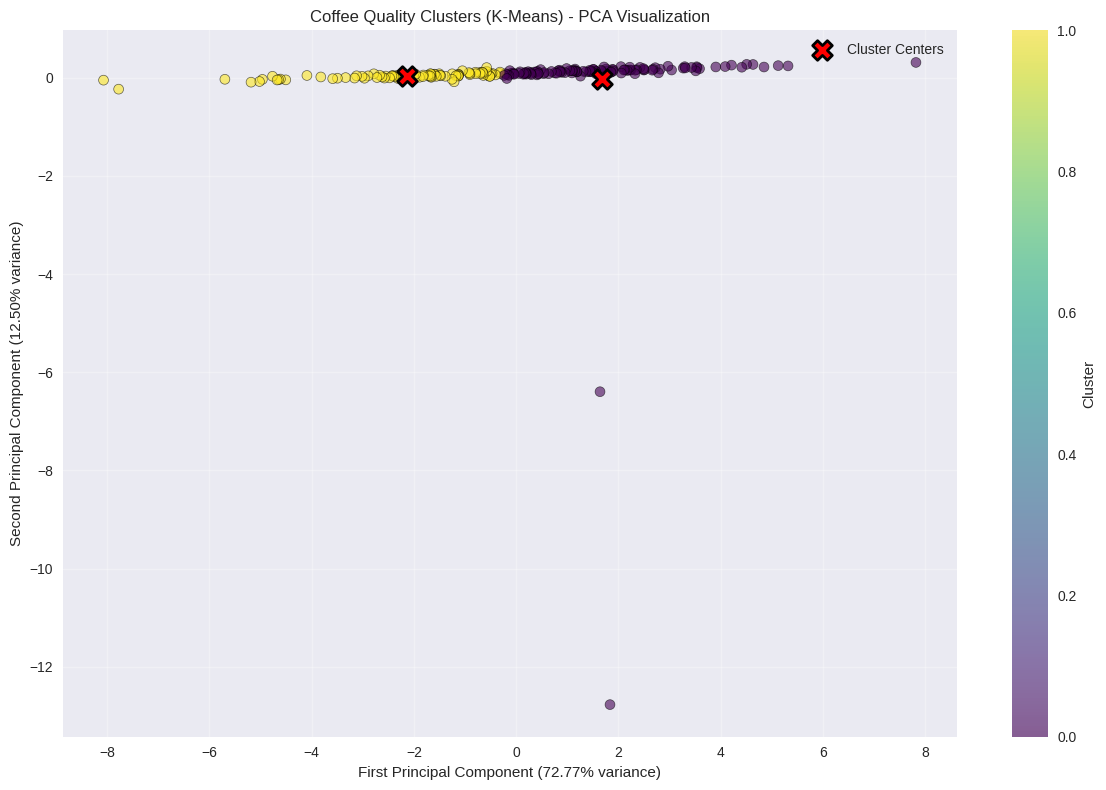

PCA explained variance: 85.27%


In [6]:

# ============================================================================
# SECTION 6: Visualize Clusters using PCA
# ============================================================================

print("\n" + "="*60)
print("PCA VISUALIZATION")
print("="*60)

# Use PCA to reduce dimensions for visualization (2D plot)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

# Plot cluster centers in PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X',
           s=200, label='Cluster Centers', edgecolors='black', linewidth=2)

plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Coffee Quality Clusters (K-Means) - PCA Visualization')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")



HIERARCHICAL CLUSTERING

Hierarchical clustering completed with 2 clusters!

Hierarchical Cluster distribution:
Hierarchical_Cluster
0    131
1     76
Name: count, dtype: int64

Hierarchical Clustering Silhouette Score: 0.380
K-Means Silhouette Score: 0.398


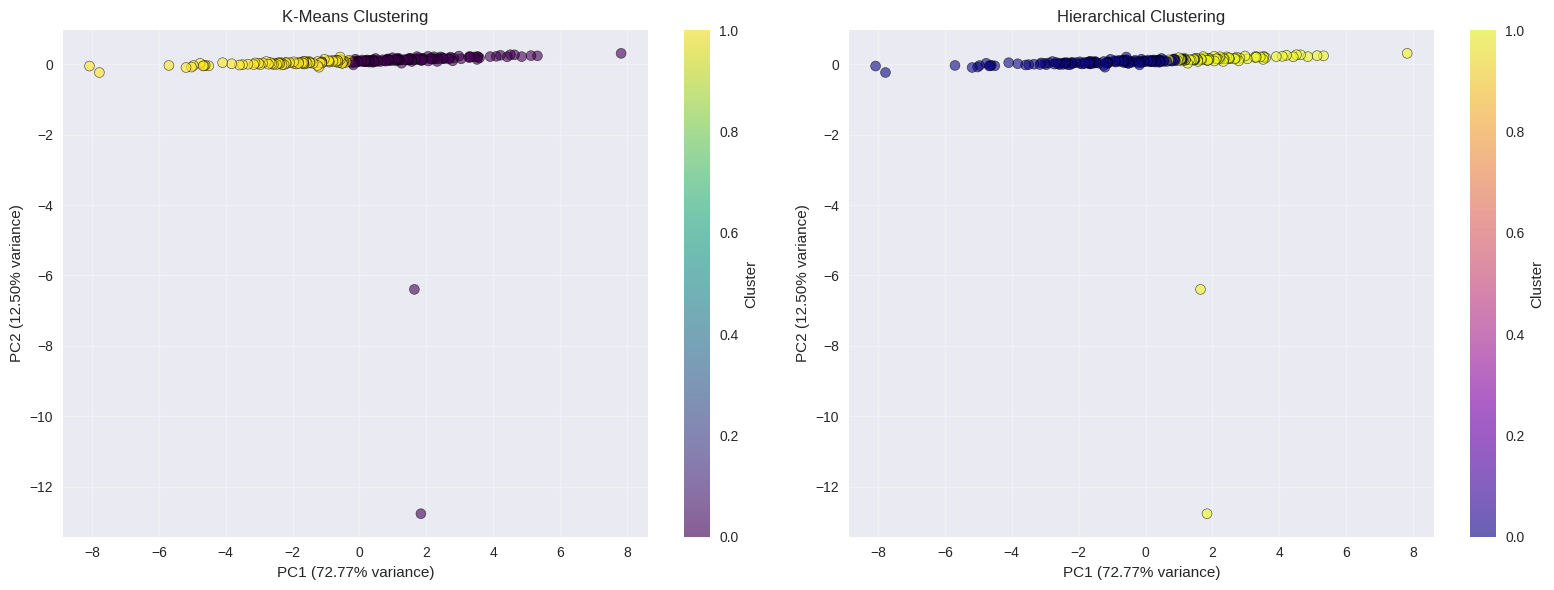

In [7]:

# ============================================================================
# SECTION 7: Hierarchical Clustering (Alternative Method)
# ============================================================================

print("\n" + "="*60)
print("HIERARCHICAL CLUSTERING")
print("="*60)

# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add hierarchical cluster labels
df_cluster_clean['Hierarchical_Cluster'] = hierarchical_labels

print(f"\nHierarchical clustering completed with {optimal_k} clusters!")
print("\nHierarchical Cluster distribution:")
print(df_cluster_clean['Hierarchical_Cluster'].value_counts().sort_index())

# Calculate silhouette score for hierarchical clustering
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
print(f"\nHierarchical Clustering Silhouette Score: {hierarchical_silhouette:.3f}")
print(f"K-Means Silhouette Score: {silhouette_avg:.3f}")

# Visualize both clustering methods
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means visualization
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                          cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('K-Means Clustering')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Hierarchical visualization
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels,
                          cmap='plasma', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title('Hierarchical Clustering')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()



INSIGHTS AND PATTERNS

Cluster Composition by Quality Category:
Quality_Category  Excellent (85-90)  Good (<80)  Very Good (80-85)
Cluster                                                           
0                                48           0                 68
1                                 0           3                 88


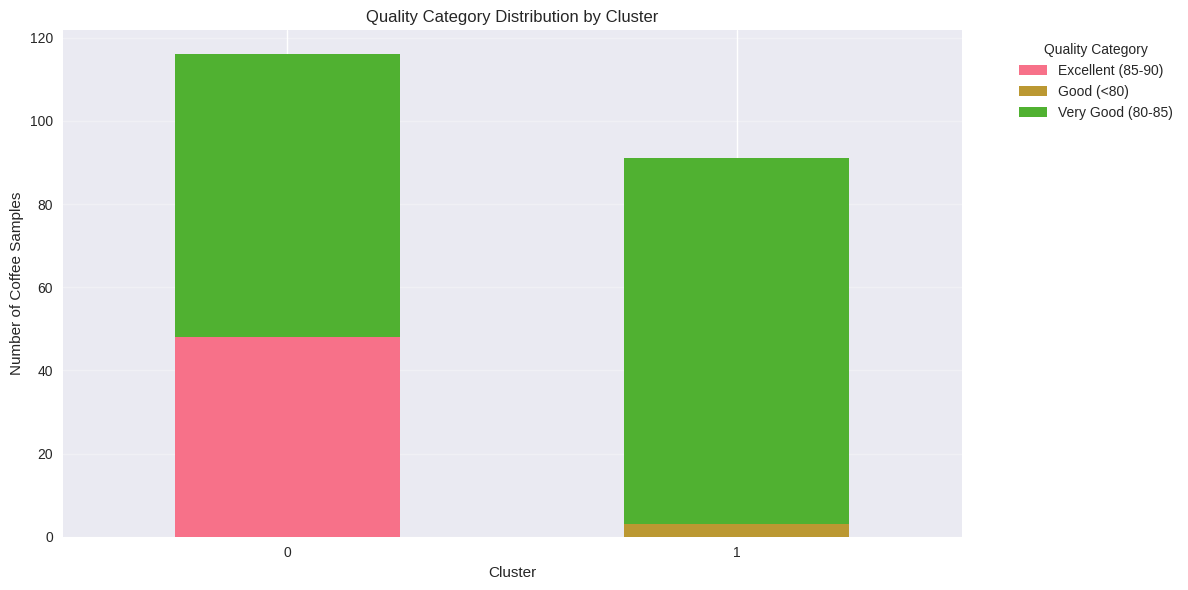


Top Quality Metrics by Cluster (Average Scores):

Cluster 0:
  Average Total Cup Points: 84.90
  Top 3 Metrics:
    1. Clean Cup: 10.00
    2. Sweetness: 10.00
    3. Uniformity: 9.98

Cluster 1:
  Average Total Cup Points: 82.19
  Top 3 Metrics:
    1. Sweetness: 10.00
    2. Clean Cup: 10.00
    3. Uniformity: 10.00


In [8]:

# ============================================================================
# SECTION 8: Insights and Patterns
# ============================================================================

print("\n" + "="*60)
print("INSIGHTS AND PATTERNS")
print("="*60)

# Identify quality categories based on Total Cup Points
def categorize_quality(points):
    if points >= 90:
        return 'Exceptional (90+)'
    elif points >= 85:
        return 'Excellent (85-90)'
    elif points >= 80:
        return 'Very Good (80-85)'
    else:
        return 'Good (<80)'

df_cluster_clean['Quality_Category'] = df_cluster_clean['Total Cup Points'].apply(categorize_quality)

# Analyze cluster composition by quality category
print("\nCluster Composition by Quality Category:")
quality_by_cluster = pd.crosstab(df_cluster_clean['Cluster'], df_cluster_clean['Quality_Category'])
print(quality_by_cluster)

# Visualize
quality_by_cluster.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Quality Category Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Coffee Samples')
plt.legend(title='Quality Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Analyze which features are most important for each cluster
print("\nTop Quality Metrics by Cluster (Average Scores):")
for cluster_id in sorted(df_cluster_clean['Cluster'].unique()):
    cluster_data = df_cluster_clean[df_cluster_clean['Cluster'] == cluster_id]
    avg_scores = cluster_data[clustering_features].mean().sort_values(ascending=False)

    print(f"\nCluster {cluster_id}:")
    print(f"  Average Total Cup Points: {cluster_data['Total Cup Points'].mean():.2f}")
    print(f"  Top 3 Metrics:")
    for i, (metric, score) in enumerate(avg_scores.head(3).items(), 1):
        print(f"    {i}. {metric}: {score:.2f}")



SUMMARY AND CONCLUSIONS

Dataset: 207 coffee samples
Features used: 10 quality metrics
Optimal number of clusters: 2
Clustering method: K-Means
Silhouette Score: 0.398

------------------------------------------------------------
CLUSTER CHARACTERISTICS:
------------------------------------------------------------

Cluster 0:
  Samples: 116 (56.0%)
  Average Quality Score: 84.90
  Strongest Aspect: Clean Cup (10.00)

Cluster 1:
  Samples: 91 (44.0%)
  Average Quality Score: 82.19
  Strongest Aspect: Uniformity (10.00)

KEY INSIGHTS:
1. Coffee samples can be grouped into distinct quality clusters
2. Each cluster has unique characteristics in quality metrics
3. Clustering helps identify patterns in coffee quality
4. This analysis can guide quality assessment and production decisions


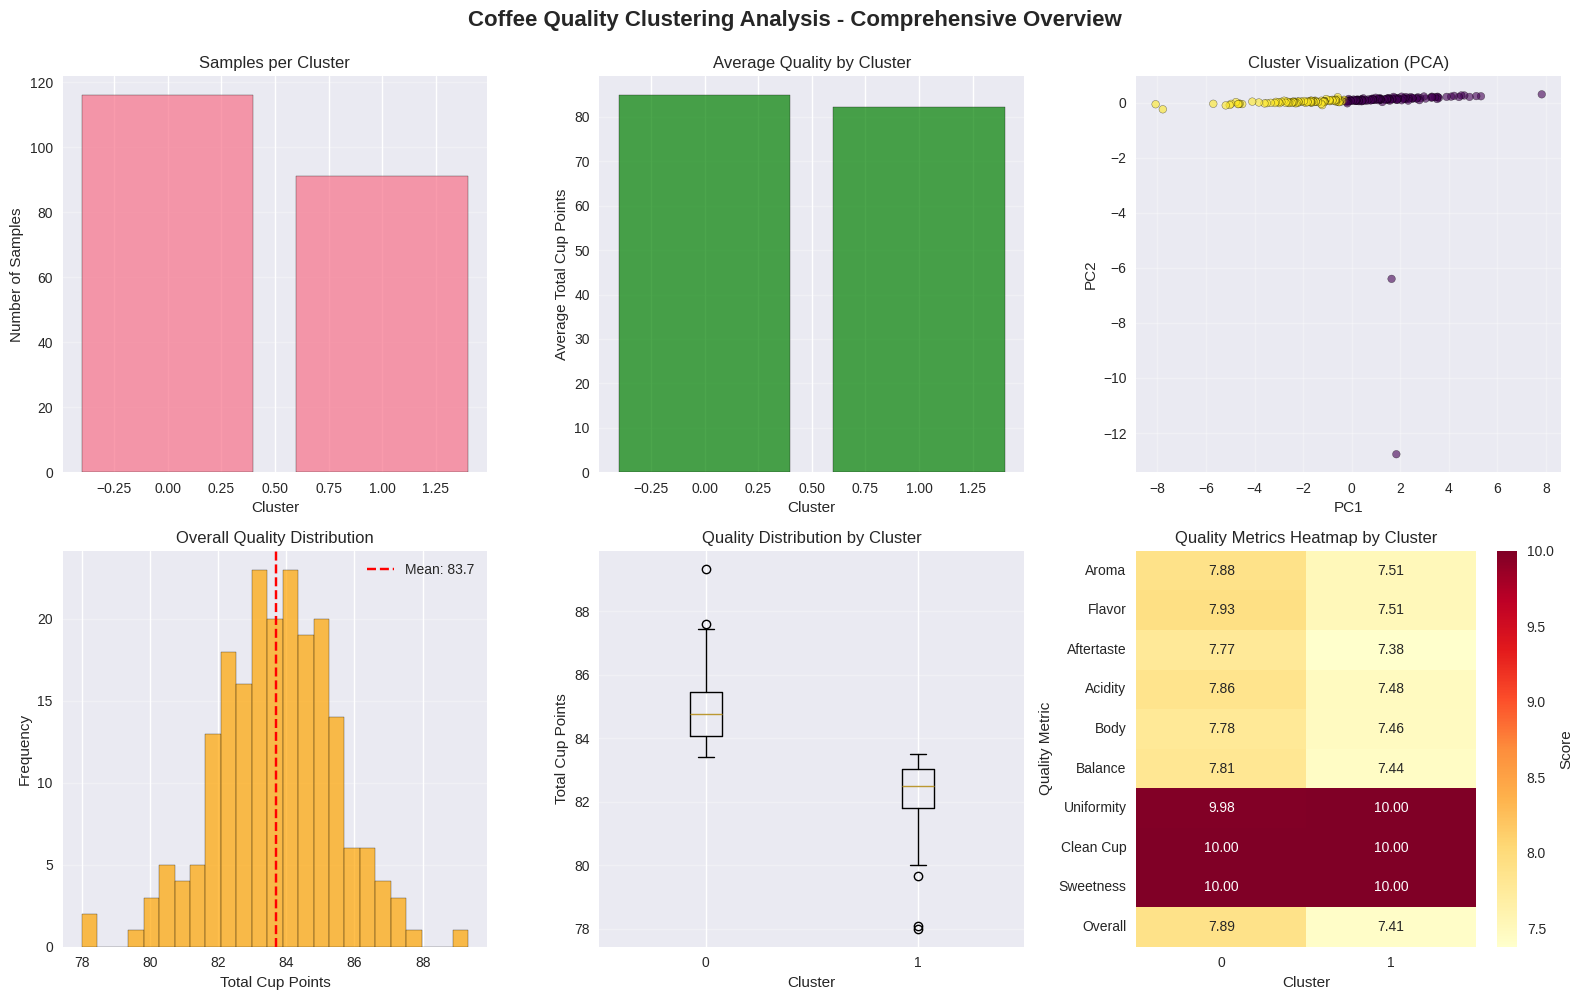


Analysis Complete! All visualizations generated.


In [9]:

# ============================================================================
# SECTION 9: Summary and Conclusions
# ============================================================================

print("\n" + "="*60)
print("SUMMARY AND CONCLUSIONS")
print("="*60)

# Final Summary
print(f"\nDataset: {len(df_cluster_clean)} coffee samples")
print(f"Features used: {len(clustering_features)} quality metrics")
print(f"Optimal number of clusters: {optimal_k}")
print(f"Clustering method: K-Means")
print(f"Silhouette Score: {silhouette_avg:.3f}")

print("\n" + "-"*60)
print("CLUSTER CHARACTERISTICS:")
print("-"*60)

for cluster_id in sorted(df_cluster_clean['Cluster'].unique()):
    cluster_data = df_cluster_clean[df_cluster_clean['Cluster'] == cluster_id]
    avg_quality = cluster_data['Total Cup Points'].mean()
    count = len(cluster_data)

    print(f"\nCluster {cluster_id}:")
    print(f"  Samples: {count} ({count/len(df_cluster_clean)*100:.1f}%)")
    print(f"  Average Quality Score: {avg_quality:.2f}")

    # Identify strongest quality aspect
    top_metric = cluster_data[clustering_features].mean().idxmax()
    top_score = cluster_data[clustering_features].mean().max()
    print(f"  Strongest Aspect: {top_metric} ({top_score:.2f})")

print("\n" + "="*60)
print("KEY INSIGHTS:")
print("="*60)
print("1. Coffee samples can be grouped into distinct quality clusters")
print("2. Each cluster has unique characteristics in quality metrics")
print("3. Clustering helps identify patterns in coffee quality")
print("4. This analysis can guide quality assessment and production decisions")
print("="*60)

# Create a comprehensive final visualization
fig = plt.figure(figsize=(16, 10))

# 1. Cluster distribution
ax1 = plt.subplot(2, 3, 1)
cluster_counts = df_cluster_clean['Cluster'].value_counts().sort_index()
ax1.bar(cluster_counts.index, cluster_counts.values, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Samples per Cluster')
ax1.grid(True, alpha=0.3, axis='y')

# 2. Average quality by cluster
ax2 = plt.subplot(2, 3, 2)
avg_quality = df_cluster_clean.groupby('Cluster')['Total Cup Points'].mean()
ax2.bar(avg_quality.index, avg_quality.values, alpha=0.7, edgecolor='black', color='green')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Average Total Cup Points')
ax2.set_title('Average Quality by Cluster')
ax2.grid(True, alpha=0.3, axis='y')

# 3. PCA visualization
ax3 = plt.subplot(2, 3, 3)
scatter = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                     cmap='viridis', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
ax3.set_xlabel(f'PC1')
ax3.set_ylabel(f'PC2')
ax3.set_title('Cluster Visualization (PCA)')
ax3.grid(True, alpha=0.3)

# 4. Quality distribution
ax4 = plt.subplot(2, 3, 4)
ax4.hist(df_cluster_clean['Total Cup Points'], bins=25, edgecolor='black', alpha=0.7, color='orange')
ax4.axvline(df_cluster_clean['Total Cup Points'].mean(), color='red',
            linestyle='--', label=f'Mean: {df_cluster_clean["Total Cup Points"].mean():.1f}')
ax4.set_xlabel('Total Cup Points')
ax4.set_ylabel('Frequency')
ax4.set_title('Overall Quality Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Cluster quality comparison
ax5 = plt.subplot(2, 3, 5)
cluster_quality_data = [df_cluster_clean[df_cluster_clean['Cluster'] == i]['Total Cup Points'].values
                       for i in sorted(df_cluster_clean['Cluster'].unique())]
ax5.boxplot(cluster_quality_data, labels=sorted(df_cluster_clean['Cluster'].unique()))
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Total Cup Points')
ax5.set_title('Quality Distribution by Cluster')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Top metrics heatmap
ax6 = plt.subplot(2, 3, 6)
cluster_metrics = df_cluster_clean.groupby('Cluster')[clustering_features].mean()
sns.heatmap(cluster_metrics.T, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax6, cbar_kws={'label': 'Score'})
ax6.set_title('Quality Metrics Heatmap by Cluster')
ax6.set_xlabel('Cluster')
ax6.set_ylabel('Quality Metric')

plt.suptitle('Coffee Quality Clustering Analysis - Comprehensive Overview',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nAnalysis Complete! All visualizations generated.")
